# Predicciones Alicante temperaturas medias

## MBIT School

# a) Importamos libreías y datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
df = pd.read_csv('valencia_clean.csv')
co = pd.read_csv('C:/Users/34610/Desktop/TFM/CO2/valencia_co2.csv')

Visualización de los DataFrames

In [3]:
# df.head()
# df.info()
# co.head()
# co.info()

Observamos que 'df' y 'co' no tienen el mismo inicio en el tiempo. Lo corregiremos después de resetear el índice.

In [4]:
# Pasamos a formato fecha la columna 'fecha'
df['fecha'] = pd.to_datetime(df['fecha'])
co['fecha'] = pd.to_datetime(co['fecha'])

# Seleccionamos la columna 'fecha' como índice
df = df.set_index('fecha', drop = True)
co = co.set_index('fecha', drop = True)

Como los datos 'co' comienzan en 1958 pero los datos de 'df' empiezan en 1948 procedemos a eliminar los valores inferiores a 1948 del DataFame de Valencia

In [5]:
# Eliminamos las fechas posteriores a 1958 en 'df'
df = df[df.index > '1957-12-31']

In [6]:
# Unimos la columna 'co2' del DataFrame 'co' a DataFrame 'df'
df = df.join(co['co2'])

# b) Comprobación manual de las variables

Comprobamos como varía la correlación al cambiar la temporalidad de los datos.

El objetivo es la selección de las variables explicativas.

In [7]:
# Correlación diaria
# df.corr()

Vamos a generar un DataFrame con distinta temporalidad para el modelo de regresión múltiple. Queremos comprobar qué variables selecciona como explicativas y los resultados que obtiene.

In [8]:
# Cambiamos la temporalidad a trimestral mediante la media por trimestre
df_q = df.resample('Q').max()

In [9]:
# Cambiamos la temporalidad a anual mediante la media por año
df = df.resample('A').max()

In [10]:
# Correlación anual
# df.corr()

Se observa que al cambiar la temporalidad de los datos de 'diarios' a 'anuales' aumenta la correlación entre las variables.

Observamos como influye ahora la variable 'co2'.

Observemos como varía la influencia de las variables explicativas según la temporalidad sobre la variable objetivo.

Para comprobar el poder explicativo de las variables explicativas también podemos usar la librería de 'Random forest'.

**Random forest para la selección de variables**

 - Modelo con temporalidad anual.

In [11]:
# Importamos librería de RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

In [12]:
# Seleccionamos las variables para temporalidad anual
X = df.drop(columns = ['tmed', 'tmax', 'tmin'], axis = 1)
y = df['tmax']

In [13]:
# Entrenamos el modelo
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

In [14]:
# Guardamos variables explicativas
importancias = rf.feature_importances_
forest_importances = pd.Series(importancias, index=X.columns)

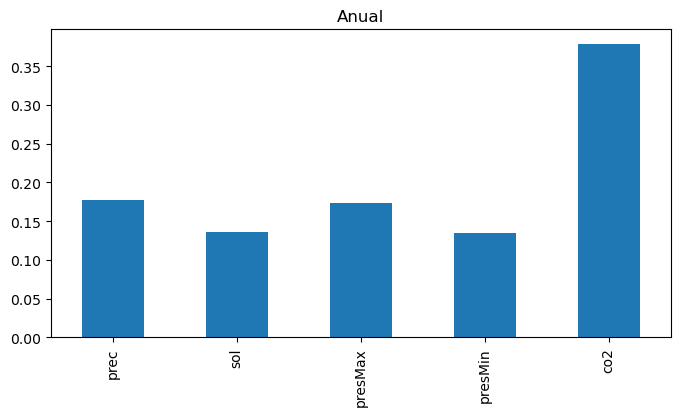

In [15]:
# Generamos el gráfico
forest_importances.plot.bar(figsize=(8, 4)).set_title('Anual');

Observamos que la variable 'co2' no explica igual de bien la evolución en temporalidad anual de 'tmax' como lo hace con 'tmed'. La variable 'tmax' es más complicada de explicar mediante las variables explicativas al correlacionar peor.

 - Modelo con temporalidad trimestral.

In [16]:
# Seleccionamos las variables para temporalidad trimestral
X_q = df_q.drop(columns = ['tmed', 'tmax', 'tmin'], axis = 1)
y_q = df_q['tmax']

In [17]:
# Entrenamos el modelo
rf_q = RandomForestRegressor()
rf_q.fit(X_q, y_q)

RandomForestRegressor()

In [18]:
# Guardamos variables explicativas
importancias_q = rf_q.feature_importances_
forest_importances_q = pd.Series(importancias_q, index=X_q.columns)

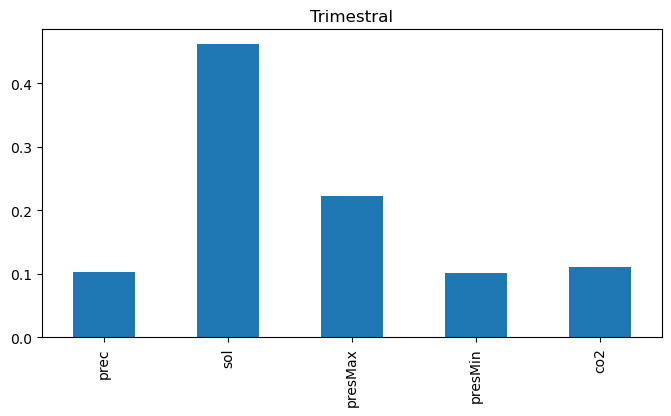

In [19]:
# Generamos el gráfico
forest_importances_q.plot.bar(figsize=(8, 4)).set_title('Trimestral');

Se observa como varía la capacidad explicativas dependiendo de la temporalidad de los datos. Para una temporalidad trimestral, muy similar a las estaciones del año, encontramos que la variable que mejor explica la vable objetivo 'tmax' es la variable explicativa 'sol'.

Aun así, comprobamos que la el resto de variables explicativas tienen mayor peso en la explicación de la variable objetivo 'tmax' que para 'tmed', visto en otra libreta

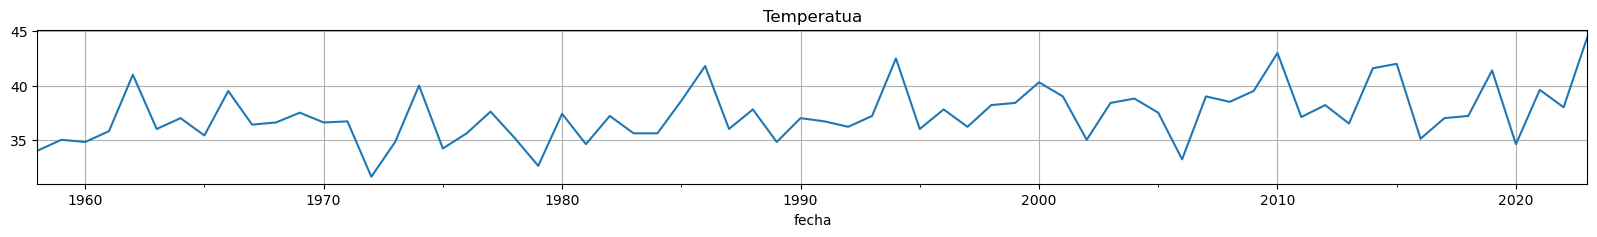

In [20]:
# Observamos la evolución de la variable a predecir 'tmax'
df['tmax'].plot(figsize = (20, 2))
plt.title('Temperatua')
plt.grid()
plt.show()

# c) Modelos de Regrsión

Los modelos de regresión sirven para analizar las relaciones entre las variables explicativas y la variable que queremos explicar, en nuestro caso las temeperaturas.

### c) I. Regresión Lineal

In [21]:
# Seleccionamos las variables
X = df[['co2']].values
y = df['tmax'].values

Dividimos nuestro DataFrame en un conjunto para entrenar y en optro para testear. Al reducir la muestra de los datos debido a la temporalidad elegida para la representación de los mismos utilizaremos el 80% de los datos para entrenar y el 30% restante para testear.

In [22]:
# Biblioteca para dividir en trin y test
from sklearn.model_selection import train_test_split

In [23]:
# Devidimos 'df' en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)
print(f'''Tamaño de los conjuntos de train y test:
- Train de X {X_train.shape}
- Test de X {X_test.shape}
- Train de y {y_train.shape}
- Test de y {y_test.shape}''')

Tamaño de los conjuntos de train y test:
- Train de X (46, 1)
- Test de X (20, 1)
- Train de y (46,)
- Test de y (20,)


In [24]:
# Biblioteca para la regresión lineal
from sklearn.linear_model import LinearRegression

# Biblioteca para medir el rendimietno de las regresiones
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
# Generamos el modelo de regresión lineal
regression_lineal = LinearRegression()
# Entrenamiento con datos de train
regression_lineal.fit(X_train, y_train)

LinearRegression()

***Evaluación de train y test***

In [26]:
# Evaluamos el rendimiento de train
y_train_predict = regression_lineal.predict(X_train)
rmse_l = mean_squared_error(y_train, y_train_predict, squared = False)
r2_l = r2_score(y_train, y_train_predict)

print(f'''Rendimiento del modelo para el conjunto de train
- R2: {r2_l}
- RMSE: {rmse_l}
''')

# Evaluamos el rendimiento de test
y_test_predict = regression_lineal.predict(X_test)
rmse_l = mean_squared_error(y_test, y_test_predict, squared = False)
r2_l = r2_score(y_test, y_test_predict)

print(f'''Rendimiento del modelo para el conjunto de train
- R2: {r2_l}
- RMSE: {rmse_l}
''')

Rendimiento del modelo para el conjunto de train
- R2: 0.17908955391573633
- RMSE: 2.4399464681770247

Rendimiento del modelo para el conjunto de train
- R2: 0.04285063724017846
- RMSE: 1.9777176093122955



El ***R2*** de ***train*** nos indica que el ***17.91%*** de nuestros datos se pueden explicar mediante el modelo de regresión lineal. En el conjunto de ***test*** baja esta capacidad de explicación al ***4.29%***.

Obtenemos valores muy pobres de R2 para 'tmax' mediante la variable explicativa 'co2'

El RMSE nos indica como de bien se ajusta nuestro modelo. Un valor menos indicará un mejor ajuste.

***Visualizamos los resultados de entrenamiento***

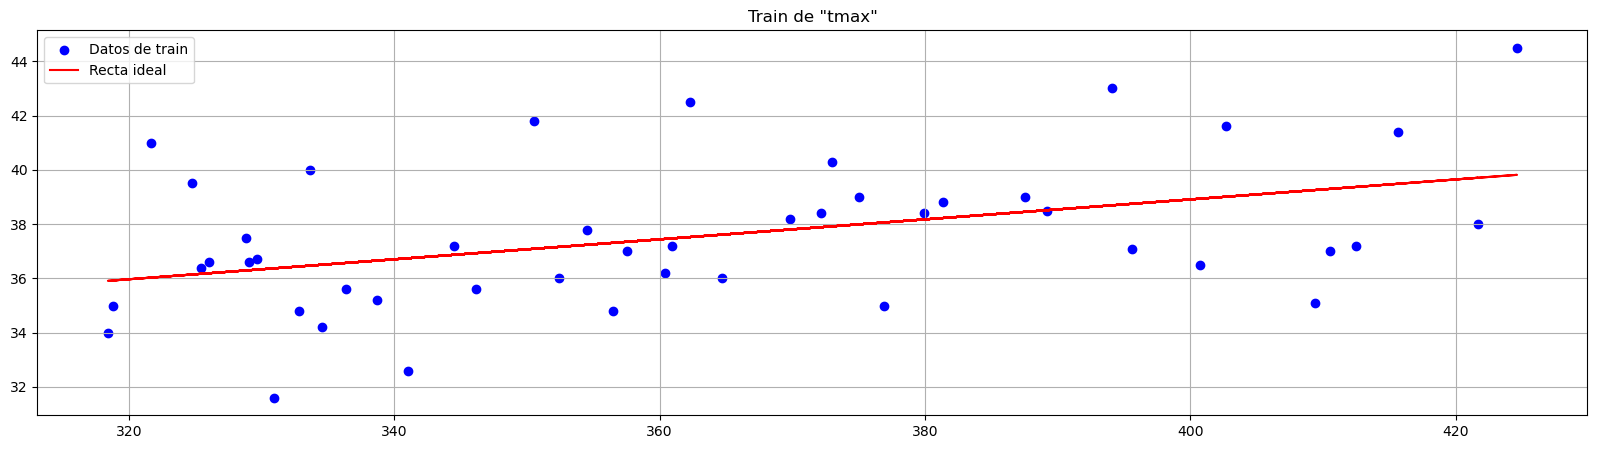

In [27]:
# Generamos un gráfico para comprobar la distribución de los datos de train (puntos) y nuestra predicción (línea)
plt.figure(figsize = (20, 5))
plt.scatter(X_train, y_train, color = 'blue', label = 'Datos de train')
plt.plot(X_train, regression_lineal.predict(X_train), color = 'red', label = 'Recta ideal')
plt.title('Train de "tmax"')
plt.grid()
plt.legend()
plt.show()

Ya nos adelantaba el resultado de R2 que nuestro modelo no se ajustaba bien.

***Visualizamos los resultados de test***

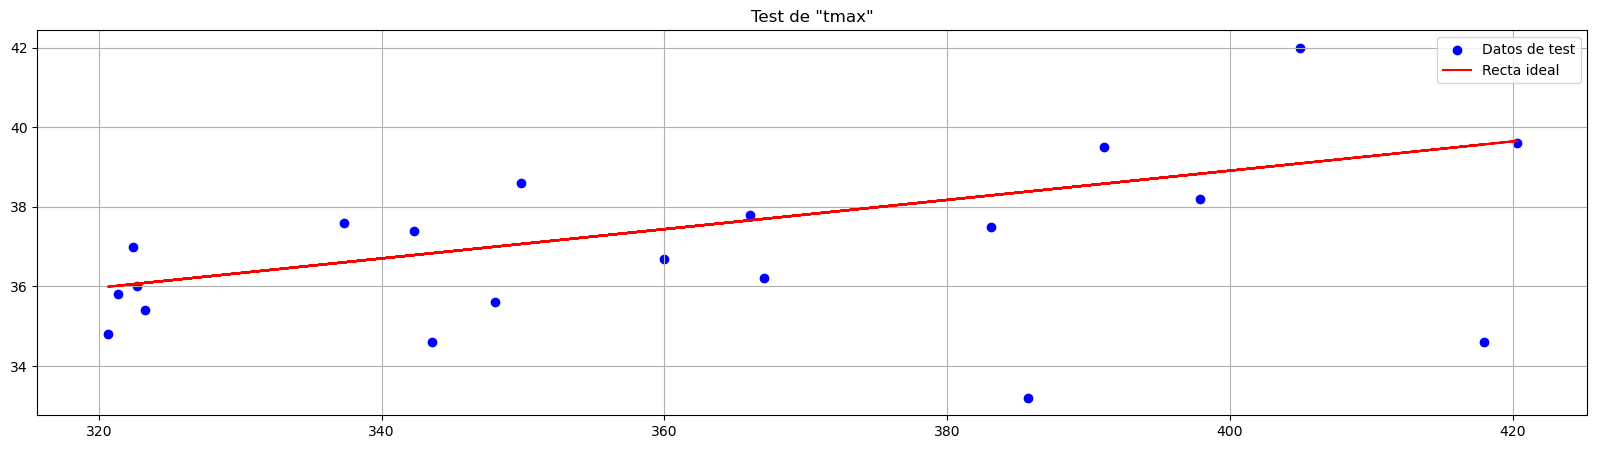

In [28]:
# Generamos un gráfico para comprobar la distribución de los datos de test (puntos) y nuestra predicción (línea)
plt.figure(figsize = (20, 5))
plt.scatter(X_test, y_test, color = 'blue', label = 'Datos de test')
plt.plot(X_test, regression_lineal.predict(X_test), color = 'red', label = 'Recta ideal' )
plt.title('Test de "tmax"')
plt.grid()
plt.legend()
plt.show()

Volvemos a comprobar en los datos de 'test' que nuestro modelo no se ajusta de forma correcta.

***Visualizamos los errores***

Vamos a comprobar por cuánto ha errado nuestro modelo en cada punto. Para ello creamos una columna que mida la diferencia entre el valor real y la predicción de nuestro modelo.

In [29]:
# Creamos una variable 'diff' que mida la desviación entre los datos de test y las predicciones
errors = pd.DataFrame([y_test, y_test_predict, y_test-y_test_predict]).T
errors.columns = 'y_test', 'y_pred', 'diff'
errors.tail()

,y_test,y_pred,diff
15,36.2,37.699864,-1.499864
16,38.6,37.065374,1.534626
17,37.8,37.662714,0.137286
18,37.0,36.056809,0.943191
19,34.6,36.835118,-2.235118


In [30]:
# Biblioteca para calcular el intervalo de confianza
from scipy import stats

Mediante la variable 'target_year' se puede modificar el año hasta el que se quiere realizar la predicción.

In [31]:
# Selección del año objetivo
target_year = 2100

# Cálculo de años que faltan hasta 'target_year' para generar el gráfico
t_y = target_year - 2024 

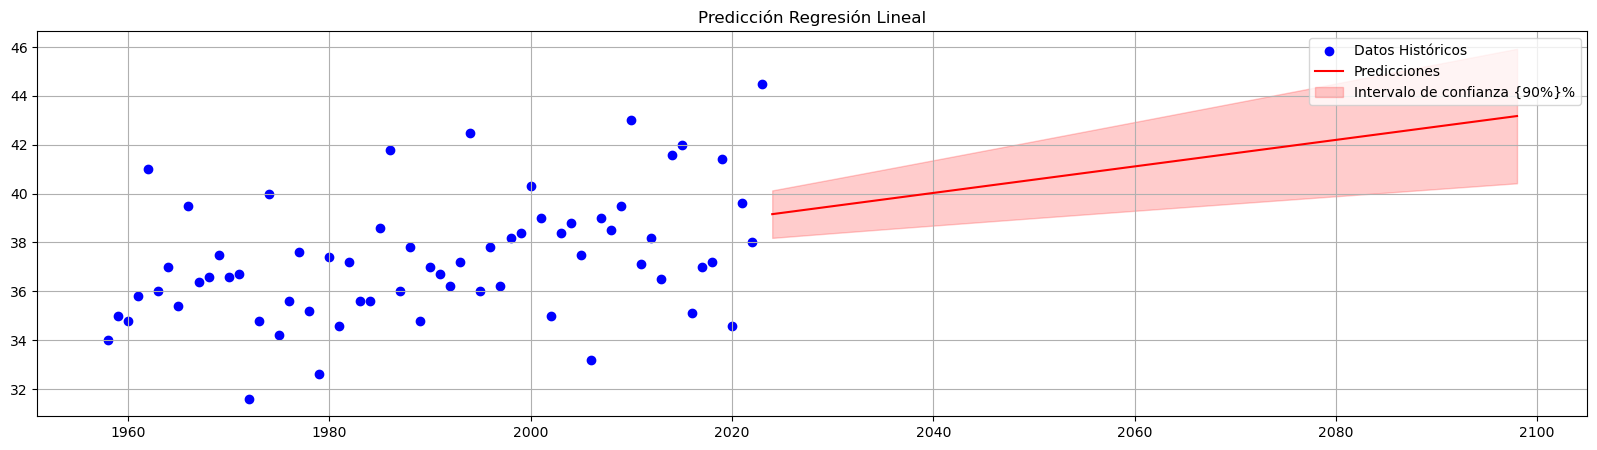

In [32]:
# Generamos una columna con los años del índice
df['year'] = df.index.year

# Seleccionamos las variables del modelo
X = df['year'].values.reshape(-1, 1)
y = df['tmax'].values

# Ajustamos el modelo de regrsión lineal
model = LinearRegression()
model.fit(X, y)

# Generamos fechas futuras y realizamos predicciones sobre ellas
future_years = np.arange(df['year'].max() + 1, df['year'].max() + t_y).reshape(-1, 1)
future_pred = model.predict(future_years)

# Calculamos el intervalo de confianza sobre la predicción y los almacenamos
predic, lower_interval, upper_interval = [], [], []
sum_squared_residuals = np.sum((y - model.predict(X)) ** 2)
n = len(y)
p_var = sum_squared_residuals / (n - 2)

# Obtenemos el valor de la distribución de t-Student superior e inferior.
# En este caso 0.95 corresponde al 90%, 5% por cada lado.
t_value = stats.t.ppf(0.95, df=n-2)

# Generamos un bucle para calcular el intervalo de confianza en cada año
for year in future_years.flatten():
    p = model.predict([[year]])[0]
    predic.append(p)
    
    interval_size = t_value * np.sqrt(p_var) * np.sqrt(1/n + (year - np.mean(X))**2 / np.sum((X - np.mean(X))**2))
    lower_interval.append(p - interval_size)
    upper_interval.append(p + interval_size)

# Generamos la gráfica
plt.figure(figsize=(20, 5))
plt.scatter(X, y, color = 'blue', label = 'Datos Históricos')
plt.plot(future_years, predic, color = 'red', label = 'Predicciones')
plt.fill_between(future_years.flatten(), lower_interval, upper_interval, color = 'red', alpha = 0.2, label = 'Intervalo de confianza {90%}%')
plt.title('Predicción Regresión Lineal')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Eliminamos la columna 'year' generada para la predicción de la gráfica anterior
df = df.drop(columns=['year'])

### c) II. Regresión Lineal Múltiple

Este tipo de modelo de regresión es capaz de captar la relación entre varias variables independientes para predecir la variable dependiente.

Somos conscientes de que no sabemos cómo van a evolucionar las distintas variables de antemano. Pero observemos cómo capta las relaciones y cómo explica el modelo de regresión lineal múltiple, con una temporalidad trimestral que se asemeja a la de las estaciones del año, la variable objetivo.

Eliminamos todas las variables que se refieran a las temperaturas de la selección de variables dependientes por motivos obvios.

In [34]:
# Seleccionamos las variables
X = df_q.drop(['tmed', 'tmin', 'tmax'], axis = 1)
y = df_q['tmax']
print(X.shape, y.shape)

(264, 5) (264,)


In [35]:
# Devidimos 'df' en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)
print(f'''Tamaño de los conjuntos de train y test:
- Train de X {X_train.shape}
- Test de X {X_test.shape}
- Train de y {y_train.shape}
- Test de y {y_test.shape}''')

Tamaño de los conjuntos de train y test:
- Train de X (184, 5)
- Test de X (80, 5)
- Train de y (184,)
- Test de y (80,)


In [36]:
# Convertimos el array a DataFrame para la selección de variables explicativas
X_train_df = pd.DataFrame(X_train, columns = X.columns)
X_test_df = pd.DataFrame(X_test, columns = X.columns)

In [37]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

Vamos a seleccionar las variables por el método 'forward', iniciando con la variable que mejor explique el modelo y añadiendo variables.

In [38]:
# Creamos un DataFrame vacío para almacenar los resultados en cada iteración
select = pd.DataFrame()

# Generamos un bucle para que seleccione las variables explicativas más relevantes, de una en adelante
for i in range(1, len(X_train_df.columns)):
    sbs = SFS(LinearRegression(), k_features = i,forward = True, floating = False)
    sbs.fit(np.array(X_train), y_train)
    sbs.k_feature_names_

    # Entrenamos el modelo con las variables seleccionada/as
    regression = LinearRegression()
    regression.fit(X_train_df[[X_train_df.columns[int(index)] for index in list(sbs.k_feature_idx_)]],
                   y_train)

    # Probamos el modelo entrenado en el conjunto de test y calculamos R2
    y_pred = regression.predict(X_test_df[[X_train_df.columns[int(index)]
                                           for index in list(sbs.k_feature_idx_)]])
    r2 = r2_score(y_pred = y_pred, y_true = y_test)

    #Almacenamos los resultados en ; DataFrame generado 'select'
    select = pd.concat([select,pd.DataFrame({
        "variables":[[X_train_df.columns[int(index)] for index in list(sbs.k_feature_idx_)]],
        "r2": r2})],ignore_index = True)

Comprobamos qué variables explican mejor el modelo:

In [39]:
# Ordenamos por mejor resultado en R2 la selección de variables del DataFrame 'selec'
select.sort_values(by = "r2", ascending = False, ignore_index = True)

,variables,r2
0,"[prec, sol, presMax, presMin]",0.414155
1,"[sol, presMax]",0.412481
2,"[prec, sol, presMax]",0.412279
3,[presMax],0.318178


Para el caso de 'tmax' no obtenemos muy buenos resultados.

 - ***Observación***

Estamos realizando la selcción de variables de forma trimestral en este modelo de ***RLM***. Mientras que en los modelos con temporalidad anual la variable explicativa más relevante era 'co2', observamos que al pasar a una temporalidad más 'cortoplacista' la variable 'co2' pasa a ser irrelevante.

Esa es una apreciación lógica debido a que las temperaturas instantáneas son generadas por las presiones, por el sol, el viento, la humedad... Pero, al visualizar los datos a largo plazo comprobamos como la variable 'co2', causante del efecto invernadero, tiene mayor relevancia en la explicación de la temperatura.

In [40]:
# Seleccionamos las variables que mejor explican nuestra variable objetivo
X = df_q[select.sort_values(by = "r2", ascending = False, ignore_index = True)["variables"][0]]
y = df_q['tmax']

Volvemo a dividir el modelo en train y test ya que difiere con el anterior al haber realizado una selección de variables más óptimo.

In [41]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

In [42]:
# Generamos el modelo de regresión múltiple
regression_mult = LinearRegression()
# Entrenamos con los datos de train
regression_mult.fit(X_train, y_train)

LinearRegression()

In [43]:
# Evaluamos el rendimiento de train
y_train_predict = regression_mult.predict(X_train)
rmse_m = mean_squared_error(y_train, y_train_predict, squared = False)
r2_m = r2_score(y_train, y_train_predict)

print(f'''Rendimiento del modelo para el conjunto de train
- R2: {r2_m}
- RMSE: {rmse_m}
''')

# Evaluamos el rendimiento de test
y_test_predict = regression_mult.predict(X_test)
rmse_m = mean_squared_error(y_test, y_test_predict, squared = False)
r2_m = r2_score(y_test, y_test_predict)

print(f'''Rendimiento del modelo para el conjunto de train
- R2: {r2_m}
- RMSE {rmse_m}
''')

Rendimiento del modelo para el conjunto de train
- R2: 0.51003691684781
- RMSE: 3.1691645779822673

Rendimiento del modelo para el conjunto de train
- R2: 0.41415537326279717
- RMSE 3.547864085019036



Observamos que los resultados del modelo de regresión lineal múltiple son mejores que los de la regresión lineal simple.

Aunque siguen siendo bastante pobres.

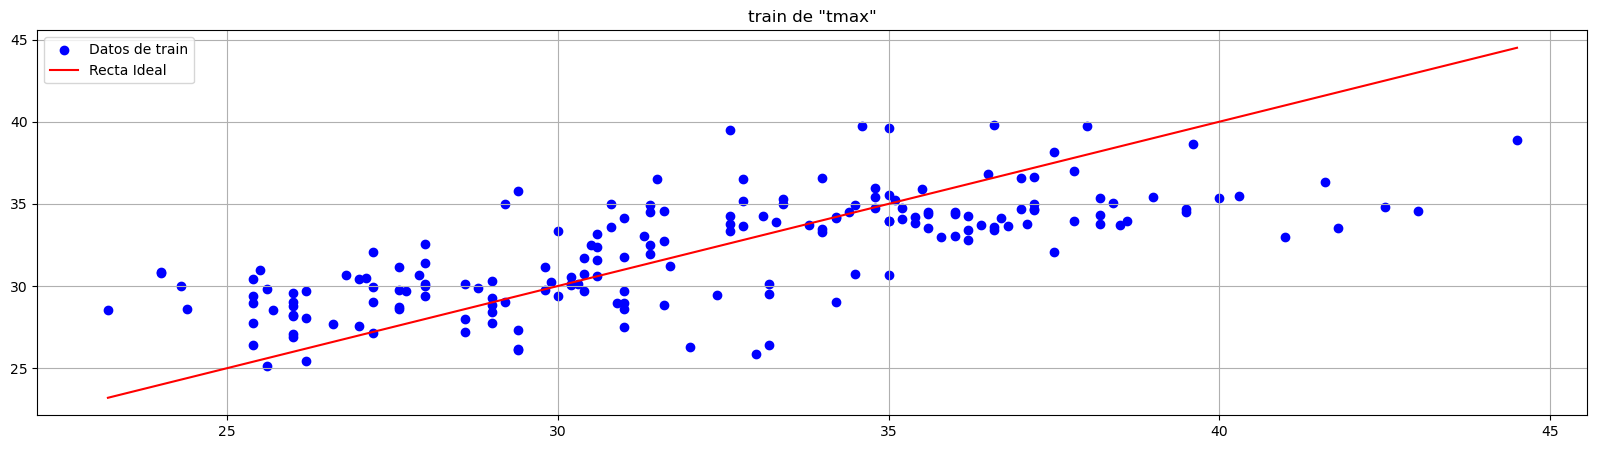

In [44]:
# Representación gráfica para el conjunto de entrenamiento
plt.figure(figsize = (20, 5))
plt.scatter(y_train, y_train_predict, color = 'blue', label = 'Datos de train')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'red', label = 'Recta Ideal')
plt.title('train de "tmax"')
plt.grid()
plt.legend()
plt.show()

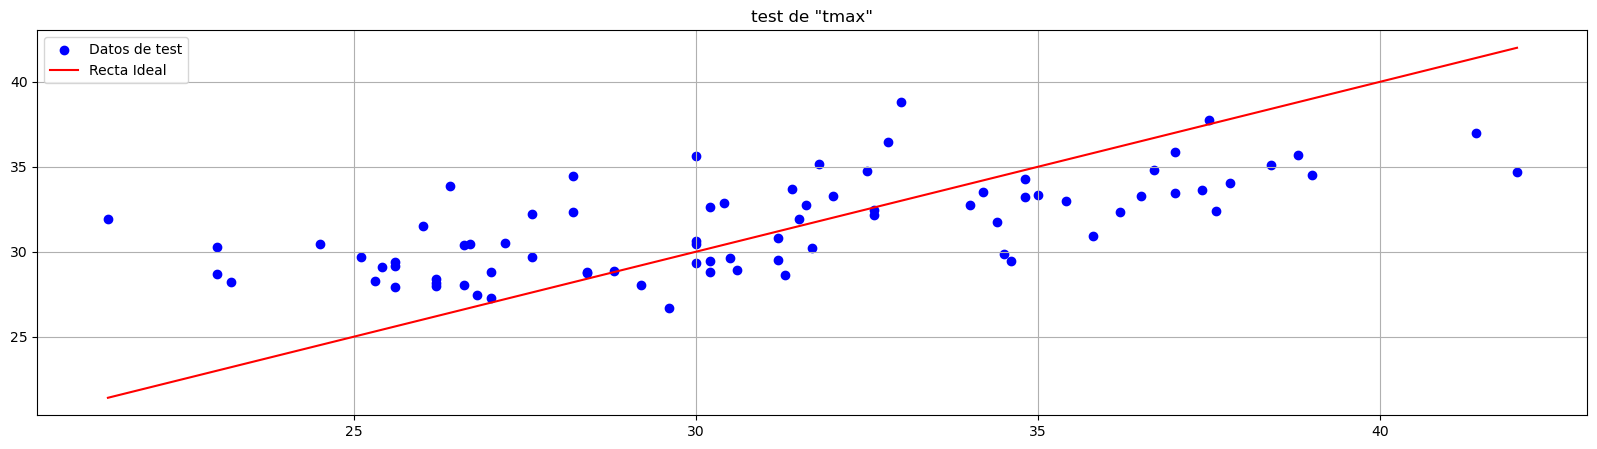

In [45]:
# Representación gráfica para el conjunto de prueba
plt.figure(figsize = (20, 5))
plt.scatter(y_test, y_test_predict, color = 'blue', label = 'Datos de test')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'red', label = 'Recta Ideal')
plt.title('test de "tmax"')
plt.grid()
plt.legend()
plt.show()

Pese a que mejora los resultados de la regresión lineal simple, los modelos que estamos obteniendo parra 'tmax' siguen sin ser satisfactorios para nuestro estudio.

### c) III. Regresión Polinómica

La regresión polinómica es una regresión lineal que ajusta los datos a una curva polinómica, al contrario que la lineal que la ajustaba a una recta.

En este tipo de modelos la selección del grado del polinomio es muy importante, puesto que un grado bajo no capturará la complejidad de los datos y un grado demasiado alto puede provocar sobreajuste.

Por este motivo definiremos una función para poder seleccionar el grado del polinomio y realizar pruebas de una forma ágil.

In [46]:
from sklearn.preprocessing import PolynomialFeatures

In [47]:
# Selecconasmo las variables
X = df[['co2']].values
y = df['tmax'].values
print(X.shape, y.shape)

(66, 1) (66,)


In [48]:
# Devidimos el dataset en train y test, dejando en test un tercio de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(46, 1) (20, 1) (46,) (20,)


***Ajustar la regresión polinómica con el dataset***

Generamos una función en la que podamos pasarle los grados del polinomio y realice los cálculos de forma automática.

In [49]:
def polynomial_regresion(X_test, X_train, degree):
    poly_features = PolynomialFeatures(degree = degree)
    X_train_poly = poly_features.fit_transform(X_train)
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    
    y_train_predict = poly_model.predict(X_train_poly)
    r2_pol = r2_score(y_train, y_train_predict)
    rmse_pol = mean_squared_error(y_train, y_train_predict, squared = False)

    print(f'''Rendimiento del modelo para el conjunto de train
    R2: {r2_pol}
    RMSE: {rmse_pol}
    ''')

    y_test_predict = poly_model.predict(poly_features.transform(X_test))
    r2_pol = r2_score(y_test, y_test_predict)
    rmse_pol = mean_squared_error(y_test, y_test_predict, squared = False)

    print(f'''Rendimiento del modelo para el conjunto de test
    R2: {r2_pol}
    RMSE: {rmse_pol}
    ''')
    
    return y_train_predict, y_test_predict

In [50]:
y_train_pred, y_test_pred = polynomial_regresion(X_test, X_train, 3)

Rendimiento del modelo para el conjunto de train
    R2: 0.18020198885263428
    RMSE: 2.438292693469604
    
Rendimiento del modelo para el conjunto de test
    R2: 0.03679506169827984
    RMSE: 1.9839639362262917
    


Una vez más observamos que no somos capaces de exlicar la variabilidad de la variable 'tmax' mediante la variable explicativa 'co2', la cuál obtenía mejores resultados para explicar la variable objetivo.

### Visualización de los resultados del Modelo Lineal Polinómico

#### Train

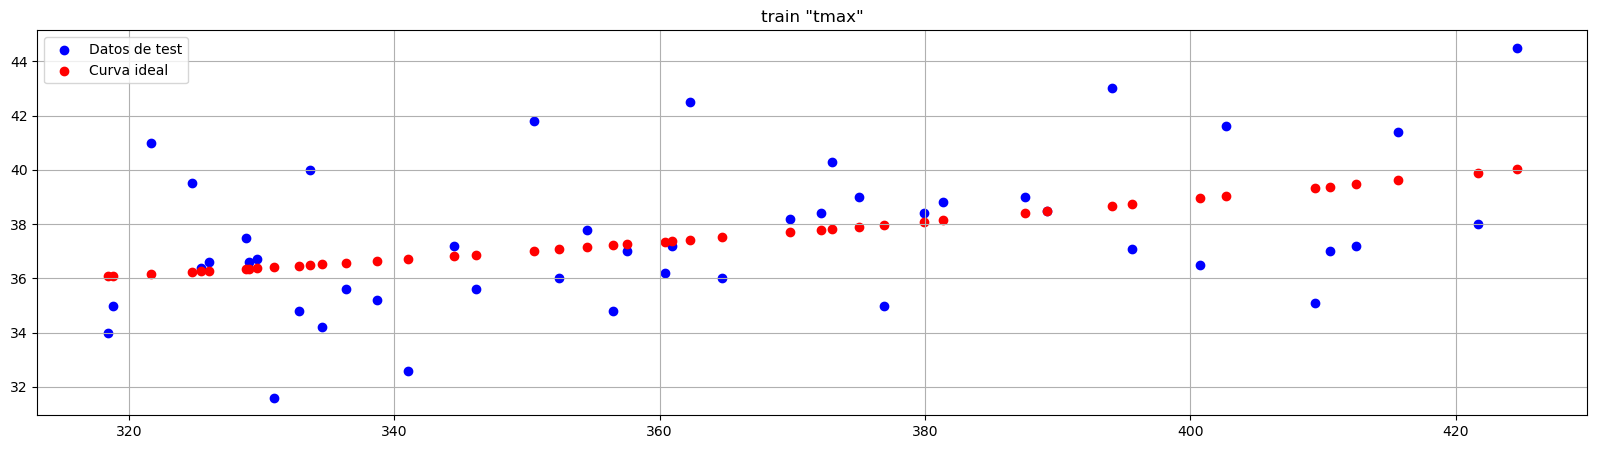

In [51]:
plt.figure(figsize = (20, 5))
plt.scatter(X_train, y_train, color = 'blue', label = 'Datos de test')
plt.scatter(X_train, y_train_pred, color = 'red', label = 'Curva ideal')
plt.title('train "tmax"')
plt.legend()
plt.grid()
plt.show()

#### Test

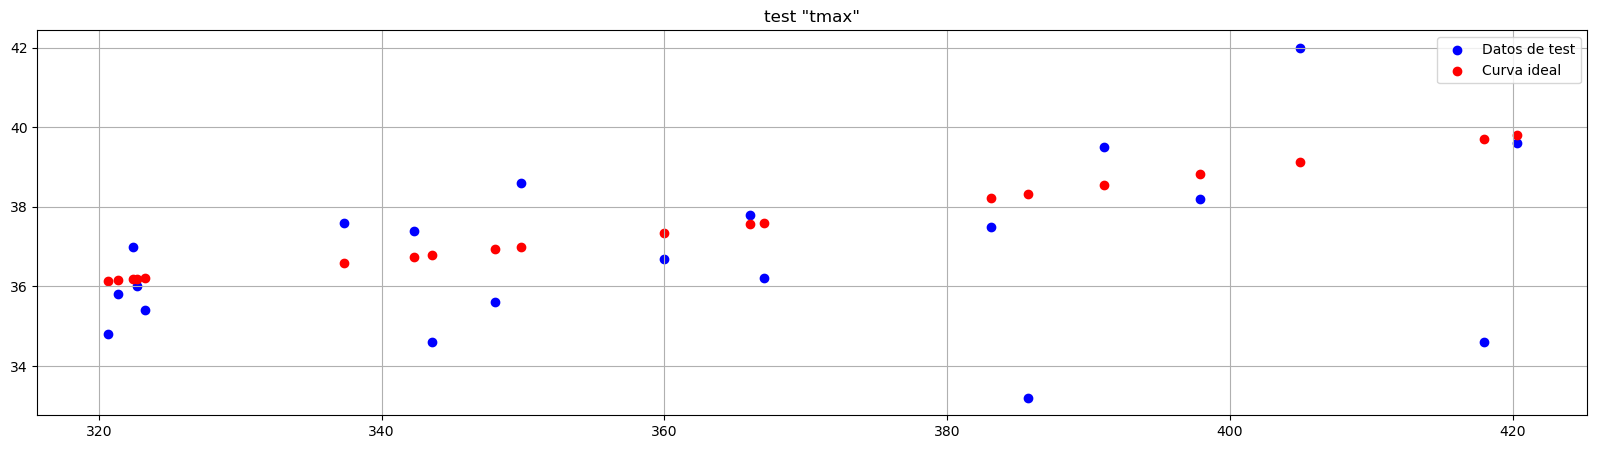

In [52]:
plt.figure(figsize=(20, 5))
plt.scatter(X_test, y_test,  color = 'blue', label = 'Datos de test')
plt.scatter(X_test, y_test_pred, color = 'red', label = 'Curva ideal')
plt.title('test "tmax"')
plt.legend()
plt.grid()
plt.show()

# e) Selección del modelo de regresión

El propósito de esta libreta es seleccionar el mejor modelo de regresión para la predicción de las temperaturas en el largo plazo. 

Entendemos qué, en el largo plazo el fenómeno que mayor influencia tiene sobre la temperatura es el dióxido de carbono (CO2). Por este motivo, el modelo seleccionado para la valoración de temperaturas futuras a largo plazo es el modelo de regresión lineal.

De este modo podremos predecir las temperaturas ayudándonos de las predicciones realizadas y guardadas en un fichero llamado 'co_future.csv', fichero que guarda las predicciones hasta el año 2100 de las cantidades de CO2 en la atmósfera.

En una sola celda ejecutamos todo el código necesario para la predicción de 'tmax'

In [53]:
# Importamos librería para guardar objetos
from joblib import dump

In [54]:
# Importamos los datos
df = pd.read_csv('valencia_clean.csv')
co = pd.read_csv('C:/Users/34610/Desktop/TFM/CO2/valencia_co2.csv')

# Pasamos a formato fecha la columna 'fecha'
df['fecha'] = pd.to_datetime(df['fecha'])
co['fecha'] = pd.to_datetime(co['fecha'])

# Seleccionamos la columna 'fecha' como índice
df = df.set_index('fecha', drop = True)
co = co.set_index('fecha', drop = True)

# Eliminamos las fechas posteriores a 1958 en 'df'
df = df[df.index > '1957-12-31']

# Unimos la columna 'co2' del DataFrame 'co' a DataFrame 'df'
df = df.join(co['co2'])

# Cambiamos la temporalidad a anual mediante la media por año
df = df.resample('A').mean()

# # Seleccionamos el inicio deseado
df = df.iloc[8:]

# Seleccionamos las variables
X = df[['co2']].values
y = df['tmax'].values

# Devidimos 'df' en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

# Generamos el modelo de regresión lineal
regression_lineal = LinearRegression()
# Entrenamiento con datos de train
regression_lineal.fit(X_train, y_train)

# Guardamos el modelo de regresión lineal entrenado en un archivo
dump(regression_lineal, 'C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/rg_l_tmax.joblib')

# # Cargamos el modelo de regresión lineal entrenado
# regression_lineal = load('regression_lineal.joblib')

['C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/rg_l_tmax.joblib']

Cargamos los datos de la predicción de la evolución del CO2 que realizamos en la libreta 'co2_prediction'. En esta libreta generamos una predicción de la evolución del CO2 hasta el año 2100.

In [55]:
# Importamos función load
from joblib import load

In [56]:
# Cargamos el DataFrame que guarda la predicción del CO2.
co_f = pd.read_csv('C:/Users/34610/Desktop/TFM/CO2/co_future.csv')

# Cargamos nuestro modelo de regresión lineal
model = load('C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/rg_l_tmax.joblib')

In [57]:
# Pasamos la columna 'fecha' a formato fecha
co_f['fecha'] = pd.to_datetime(co_f['fecha'])

# Seleccionamos la columna 'fecha' como índice
co_f = co_f.set_index('fecha', drop = True)

# Cambiamos la temporalidad de los datos a tipo anual
co_f = co_f.resample('A').mean()

Ahora seleccionamos la variable predicha a futuro 'co2' y realizamos las predicciones con nuestro modelo entrenado de regresión lineal.

In [58]:
# Seleccionamos la columna 'co2' del DataFrame 'co_f'
X_f = co_f[['co2']].values

# Con el modelo cargado de regresión lineal realizamos las predicciones
y_f_pred = model.predict(X_f)

# Guardamos las predicciones en un DataFrame para su visualización
tmax_f = pd.DataFrame({
    'tmax': y_f_pred
}, index=co_f.index)

# Renombramos el índice
tmax_f.indexname = 'fecha'

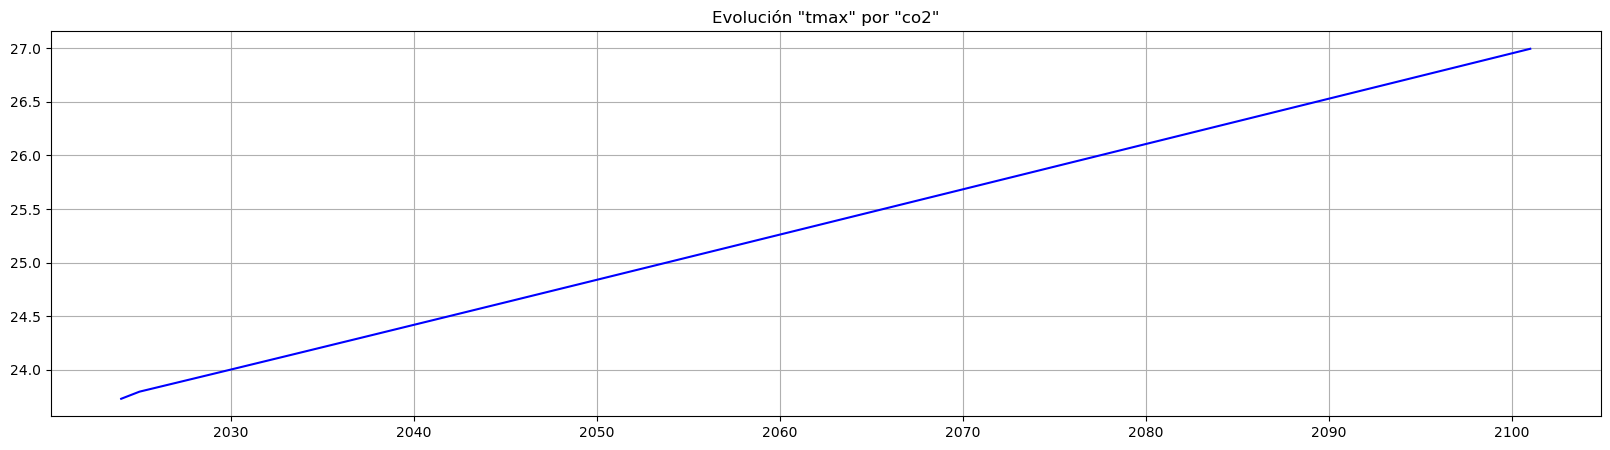

In [59]:
# Visualizamos la evolución de las temperaturas
plt.figure(figsize = (20, 5))
plt.plot(tmax_f.index, tmax_f['tmax'], color = 'blue')
plt.title('Evolución "tmax" por "co2"')
plt.grid()
plt.show()

Realizamos una pequeña comprobación:

In [60]:
# Cambio de 'tmax' en 'df' y 'tmax_future'
df_tmax_diff = df.tmax.max() - df.tmax.min()
tmax_f_diff = tmax_f.tmax.max() - df.tmax.max()

print(f'''
La temperatura máxima media anual:
- En {df.shape[0]} años ha subido {round(df_tmax_diff, 2)} grados, una media de {round((df_tmax_diff/df.shape[0]), 2)} grados al año.
- El modelo que hemos creado prevé que las temperaturas suban {round(tmax_f_diff, 2)} grados en {tmax_f.shape[0]} años, una media de {round((tmax_f_diff/tmax_f.shape[0]), 2)} grados al año.
- Se prevé que para el año 2100 la temperatura sea de {round(tmax_f.tmax.max(), 2)} frente a la media de {round(df['tmax'].iloc[-1], 2)} grados actuales
''')


La temperatura máxima media anual:
- En 58 años ha subido 3.49 grados, una media de 0.06 grados al año.
- El modelo que hemos creado prevé que las temperaturas suban 2.86 grados en 78 años, una media de 0.04 grados al año.
- Se prevé que para el año 2100 la temperatura sea de 26.99 frente a la media de 24.14 grados actuales



No hemos sido capaces de obtener buenos resultados para las predicciones de las temperaturas máximas. 

Por lo que, para el cálculo de las temperaturas máximas para las olas de calor utilizaremos otro método más creativo.